In [10]:
"""
QPSK Transmitter + Receiver Simulation

1. Generate bits
2. QPSK modulation
3. Pulse filtering
4. Channel
5. Matched filter
6. Symbol timing synchronization
7. Carrier frequency and phase recovery
8. Demodulation
9. Analysis

TODO: 
- Add multipath effects to channel & equalizer
- Framing? Detect start of frame


Framing: 
1. Initial coarse CFO guess by examining phase drift of first correlation peak's preamble
2. Correct this CFO
3. Run frame detector on corrected symbols. Have this at 2+ SPS to make robust to fractional STO
4. On frame detection: Run data aided Costas, Gardner, etc. on preamble and decision-directed on payload. Coherently demodulate corrected payload
    - Occasionally update coarse CFO guess using phase drift of preamble correlation.



Date created: 6/9/25
Author: Cole Delong
"""

"\nQPSK Transmitter + Receiver Simulation\n\n1. Generate bits\n2. QPSK modulation\n3. Pulse filtering\n4. Channel\n5. Matched filter\n6. Symbol timing synchronization\n7. Carrier frequency and phase recovery\n8. Demodulation\n9. Analysis\n\nTODO: \n- Add multipath effects to channel & equalizer\n- Framing? Detect start of frame\n\n\nFraming: \n1. Initial coarse CFO guess by examining phase drift of first correlation peak's preamble\n2. Correct this CFO\n3. Run frame detector on corrected symbols. Have this at 2+ SPS to make robust to fractional STO\n4. On frame detection: Run data aided Costas, Gardner, etc. on preamble and decision-directed on payload. Coherently demodulate corrected payload\n    - Occasionally update coarse CFO guess using phase drift of preamble correlation.\n\n\n\nDate created: 6/9/25\nAuthor: Cole Delong\n"

In [10]:
# Reload imports every time this cell is run
%reload_ext autoreload
%autoreload 2

# Imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

import sys
sys.path.insert(0, '..')
# import importlib
import py_utils
# importlib.reload(utils)
from py_utils import *
import py_sdrlib as sdr

# Constants
SPS = int(2)
N_BITS = 10**6
N_SYMBOLS = int(N_BITS/2) + 1       # qpsk: 2 bits/sample, differential coding: +1 symbol
N_RRC_TAPS = SPS*10 + 1
SNR_DB = 20


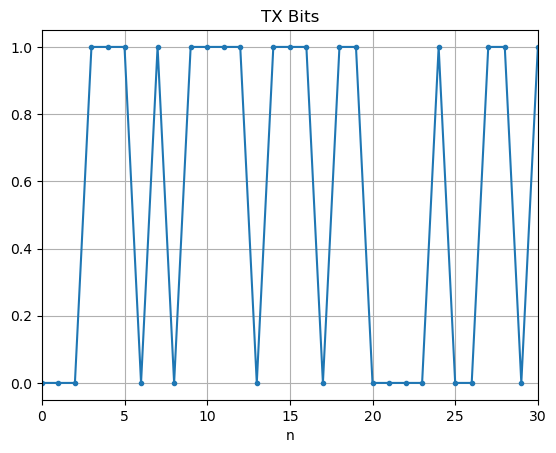

In [12]:
### Generate bits ###
bits_tx = np.random.randint(2, size=N_BITS)
plot_signal(bits_tx, title='TX Bits', xlim=[0, 30])

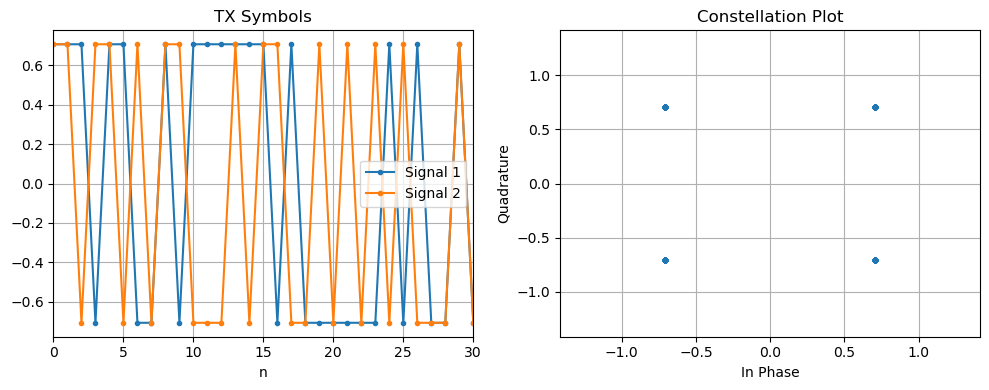

In [13]:
### QPSK modulation ###

# Use differential coding to account for phase ambiguity
sym_tx = diff_encode_psk_symbols(modulate_qpsk(bits_tx))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sym_tx.real, sym_tx.imag, title='TX Symbols', xlim=[0, 30], ax=axs[0])
plot_constellation(sym_tx, ax=axs[1])
plt.tight_layout()
plt.show()

/home/cddelong/sdr/sdr-notebooks/notebooks/../py_utils/visualization.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


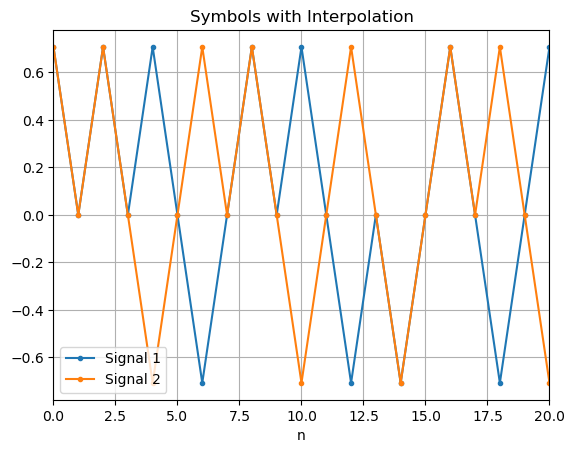

In [14]:
### Pulse filtering ###

# Upsample by factor of SPS
sym_upsamp = upsample(sym_tx, SPS)

plot_signal(sym_upsamp.real, sym_upsamp.imag, title='Symbols with Interpolation', xlim=[0, 10*SPS])

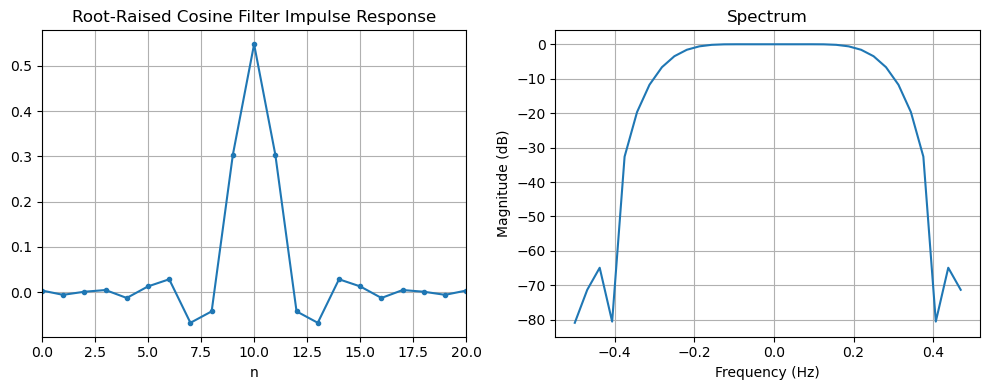

In [3]:
h_rrc = rrc(Ts=SPS, n_taps=N_RRC_TAPS)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(h_rrc.real, title='Root-Raised Cosine Filter Impulse Response', ax=axs[0])
plot_spectrum(h_rrc, ax=axs[1])
plt.tight_layout()
plt.show()

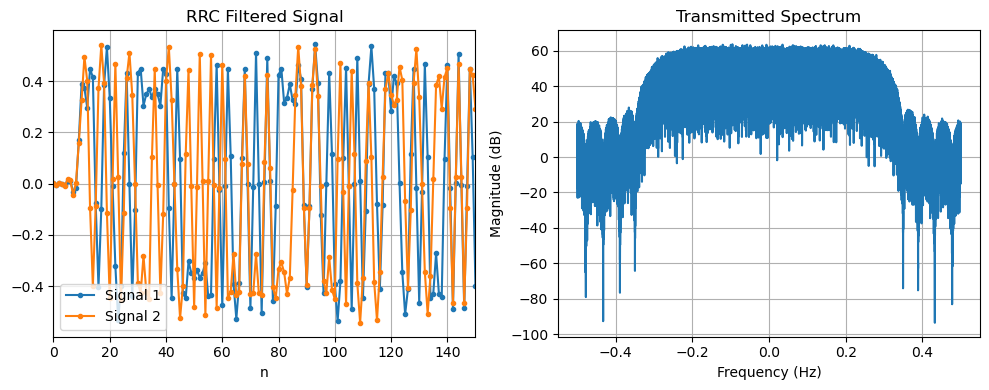

In [16]:
# Convolve signal with RRC filter
sig_tx = np.convolve(sym_upsamp, h_rrc)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_tx.real, sig_tx.imag, title='RRC Filtered Signal', xlim=[0, 150], ax=axs[0])
plot_spectrum(sig_tx, title="Transmitted Spectrum", ax=axs[1])
plt.tight_layout()
plt.show()

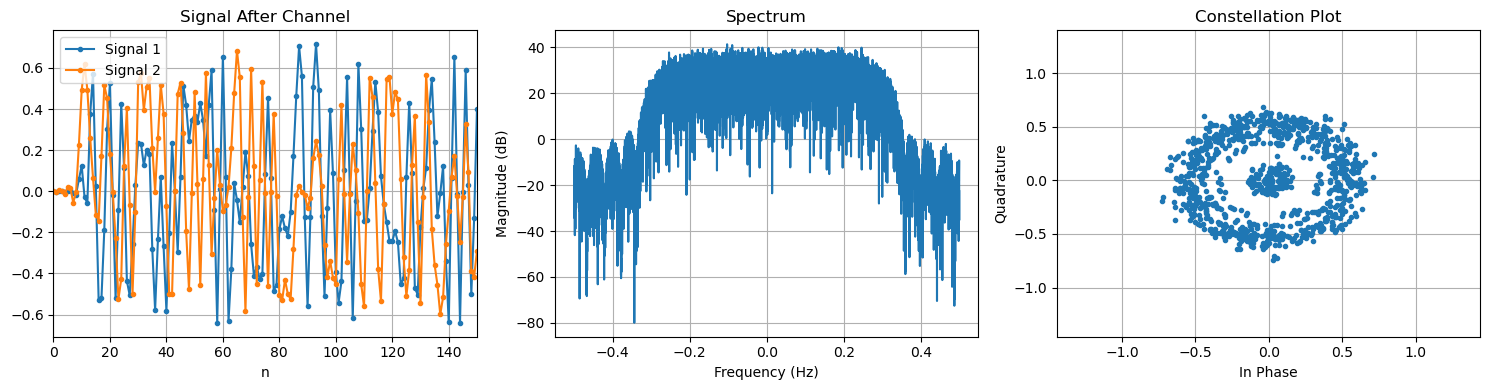

In [17]:
### Channel ###

# Apply CFO
# testing/realistic: 1-5%, aggressive: 10%
sig_chan = 0
sig_chan = apply_cfo(sig_tx, 0.01)
# sdr.apply_cfo(sig_tx, sig_chan, len(sig_tx), 0.01)


# # Apply CPO
# sig_chan = apply_cpo(sig_chan)

# # Apply STO
# mu = 0.3
# sig_chan = apply_sto(sig_chan, mu)

# # AWGN
# sig_chan = apply_awgn(sig_chan, SNR_DB)

sig_rx = sig_chan

# Visualize signal after channel
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_signal(sig_rx.real, sig_rx.imag, title='Signal After Channel', xlim=[0, 150], ax=axs[0])
plot_constellation(sig_rx, ax=axs[2])
plot_spectrum(sig_rx, n_samples=2**13, ax=axs[1])
plt.tight_layout()
plt.show()


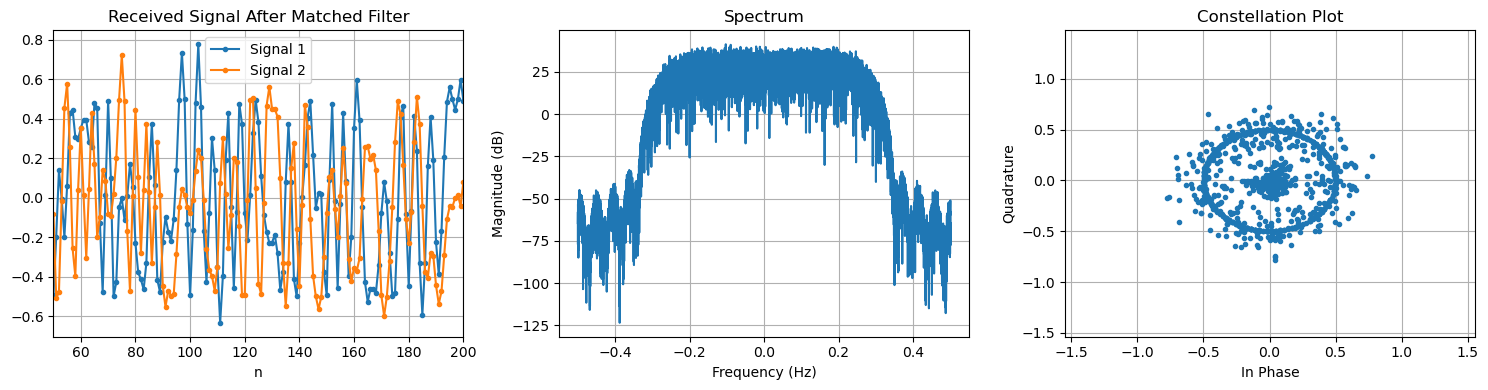

In [18]:
### Matched filter ###
sig_matched = np.convolve(sig_rx, h_rrc)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_signal(sig_matched.real, sig_matched.imag, xlim=[50, 200], title='Received Signal After Matched Filter', ax=axs[0])
plot_spectrum(sig_matched, n_samples=2**13, ax=axs[1])
plot_constellation(sig_matched, n_samples=1000, ax=axs[2])
plt.tight_layout()
plt.show()

# Remove extra samples from convolutions
sig_matched = sig_matched[N_RRC_TAPS-1 : (N_RRC_TAPS-1) * -1]


/home/cddelong/miniconda3/envs/dsp/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/cddelong/miniconda3/envs/dsp/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


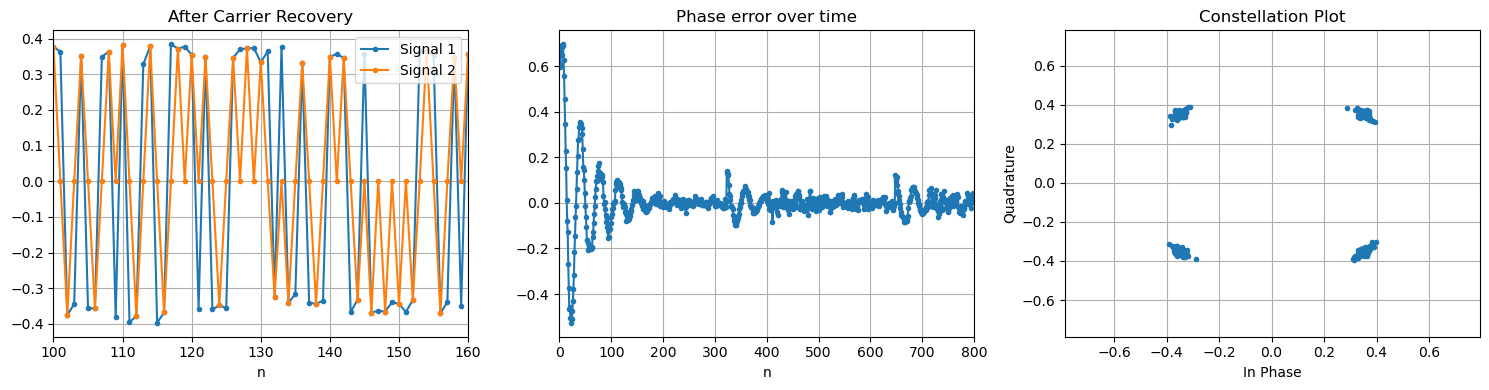

In [19]:
### Symbol Synchronization ###

"""
Gardner: 
- Low complexity
- 2x oversampling fine since sample rate is same for both rx and tx on PlutoSDR
- Better than M&M in lower SNR environments
- Real-time low-latency

cubic interpolation:
- Complexity not bad (better than sinc) when using Farrow structures
- More accurate than lower order quadratic interpolaters
"""

import py_sdrlib as sdr

stc = GardnerSymbolTimingCorrector()
symbols_sampled = stc.correct_batch(sig_matched)


### Carrier Recovery ###
# 2nd Order Costas Loop
K_p = 0.04
K_i = 0.03

control = sdr.PIDFeedback(K_p, K_i)
lock_detector = PhaseLockDetector()
error = np.empty_like(symbols_sampled)
sym_rot = costas_loop(symbols_sampled, control, lock_detector, debug=error)
symbols = np.array([sym_rot[i]*(i % SPS == 0) for i in np.arange(sym_rot.size)], dtype=sym_rot.dtype)


# Add in before + after plots for (carrier recovery), (symbol timing recovery) 
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_signal(sym_rot.real, symbols.real, title='After Carrier Recovery', xlim=[50*SPS, 80*SPS], ax=axs[0])
plot_signal(error, title='Phase error over time', xlim=[0, 800], ax=axs[1])
plot_constellation(sym_rot[1000:], n_samples=1000, ax=axs[2])
plt.tight_layout()
plt.show()



In [20]:
### Demodulation ###

# Make optimum decision for AWGN channel
bits_rx = demodulate_qpsk(diff_decode_psk_symbols(optimum_decider_qpsk(sym_rot)))

print(f"BER: {np.mean(bits_tx != bits_rx)}")

ValueError: operands could not be broadcast together with shapes (1000000,) (997266,) 

In [ ]:
print(bits_tx[0:15])
print(bits_rx[0:15])
locs = []
for i in range(len(bits_tx)):
    if bits_tx[i] != bits_rx[i]:
        locs.append(i)

print(np.sum(bits_rx != bits_tx))